In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

In [2]:
## Load and prepare data.
data = read_csv(os.path.join('data', 'data.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data', 'reject.csv'))
data = data.loc[data.subject.isin(reject.query('reject==0').subject)]

data = data.dropna()

df = read_csv('stan_results/1pl_lltm_m0_summary.csv', index_col=0, comment='#')
theta = df.T.filter(regex='theta').T['Mean'].values
data['theta'] = theta[np.unique(data.subject, return_inverse=True)[-1]]

#### rt explorations

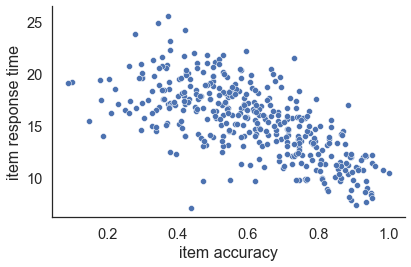

In [5]:
agg = {'rt':'median','accuracy':'mean'} 
gb = data.groupby('item_id').agg(agg)

fig, ax = plt.subplots(1,1,figsize=(6,4))

sns.scatterplot(x='accuracy', y='rt', data=gb, ax=ax)
ax.set(xlabel='item accuracy', ylabel='item response time')

sns.despine()
plt.tight_layout()

<AxesSubplot:xlabel='rt', ylabel='Density'>

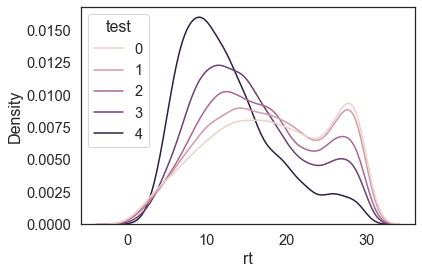

In [6]:
bins = data.groupby('item_id').accuracy.mean().quantile(np.arange(0.2,1.0,0.2))
f = lambda x: np.digitize(x.mean(), bins)
data['test'] = data.groupby('item_id').accuracy.transform(f)
sns.kdeplot(x='rt', hue='test', data=data)

<AxesSubplot:xlabel='drt', ylabel='accuracy'>

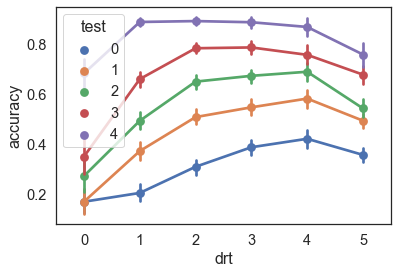

In [8]:
data['drt'] = np.digitize(data.rt, np.arange(5, 30, 5))
sns.pointplot(x='drt', y='accuracy', hue='test', data=data)

In [ ]:
data['rt_demean'] = data.groupby('item_id').rt.transform(lambda x: x - x.mean())
sns.pointplot(
    x=np.digitize(data.rt_demean, data.rt_demean.quantile(np.arange(0.2,1.0,0.2))),
    y=data.accuracy,
    hue=data.test
)

one idea is to model response times. through incorporating subject ability as regressor, then we can better resolve the subject ability terms. In doing so, the hope would be that we would have more power to resolve the discrimination parameter. 

intuitively, the relationships should be something like: 
- item difficulty determines mean response time
- subject ability helps determine dispersion around mean

the weird thing you want to be able to predict is that lower ability individuals should be at either end of the distribution. that is, fast responses are more likely to be inaccurate and from low ability participants. similarly, slow responses are more likely to be inaccurate and from low ability participants.

the trickiness here is that these should be from very different proceses. fast responses should be guessing, slow responses should be from lower ability.

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(7,4))

data['sum_score'] = data.groupby('subject').accuracy.transform(np.sum)
sns.pointplot(x='sum_score', y='rt', hue='test', data=data, estimator=np.median)

ax.set(xticklabels=np.arange(1,17), xlabel='sum score', ylabel='response time')
ax.legend(loc=7, bbox_to_anchor=(1.25,0.5), title='diffuculty')

sns.despine()
plt.tight_layout()

In [ ]:
data['theta_c'] = np.digitize(data.theta, np.arange(-1.5, 1.75, 0.25))
sns.pointplot(x='theta_c', y='rt', hue='test', data=data, estimator=np.median)

In [ ]:
from scipy.stats import spearmanr

fig, ax = plt.subplots(1,1,figsize=(6,4))

data['iia'] = data.groupby('item_id').accuracy.transform(np.mean)
f = lambda x: x[['iia','rt']].corr().iloc[0,1]
corr = data.groupby('subject').apply(f)
scores = data.groupby('subject').accuracy.sum()

sns.pointplot(x=scores, y=corr)
ax.set(xticklabels=np.arange(1,17), xlabel='sum score', ylabel='corr(RT, Difficulty)')

spearmanr(corr, scores)

sns.despine()
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

agg = {'accuracy':'sum', 'rt':'median'}
gb = data.groupby('subject').agg(agg)

sns.stripplot(x='accuracy', y='rt', data=gb, s=3, jitter=0.3, zorder=-1)
sns.pointplot(x='accuracy', y='rt', data=gb, ci=None, estimator=np.median, color='0.4')
ax.set(xticklabels=np.arange(1,17), xlabel='sum score', ylabel='response time')

sns.despine()

#### checking for evidence of guessing

In [ ]:
data['theta_c'] = np.digitize(data.theta, np.arange(-1.5, 1.75, 0.25))
ax = sns.pointplot(x='theta_c', y='accuracy', hue='test', data=data)
ax.axhline(0.25)

(-0.01, 1.01)

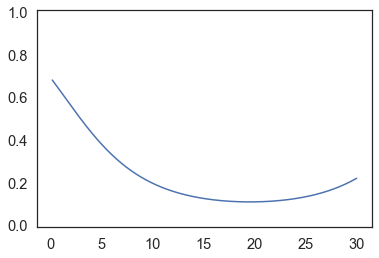

In [29]:
def inv_logit(x):
    return 1 / (1 + np.exp(-x))

x = np.sort(data.rt.values)
z = np.log(x)
z = (x - x.mean()) / x.std()
z2 = np.square(z)

b0 = -2
b1 = -0.4
b2 = 0.4
mu = inv_logit(b0 + b1 * z + b2 * z2)

plt.plot(x, mu)
plt.ylim(-0.01,1.01)

(-0.05, 1.05)

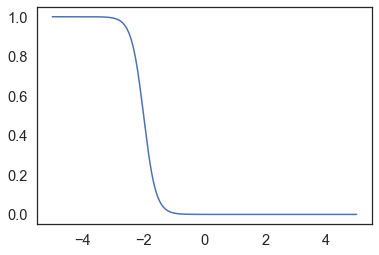

In [39]:
x = np.linspace(-5,5,1001)

b0 = -10
b1 = -5
b2 = 0

mu = inv_logit(b0 + b1 * x + b2 * x**2)
plt.plot(x, mu)
plt.ylim(-0.05,1.05)

(-0.05, 1.05)

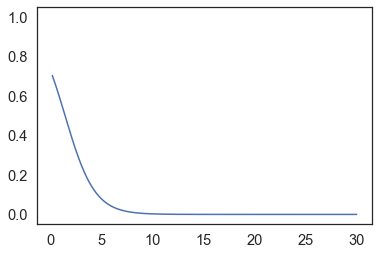

In [62]:

x = np.sort(data.rt.values)
z = np.log(x)
z = (x - x.mean()) / x.std()
z2 = np.square(z)

b0 = -2
b1 = -5
b2 = -0

mu = inv_logit( b1 * (z - b0) + b2 * (z - b0)**2 )
plt.plot(x, mu)
plt.ylim(-0.05,1.05)

In [83]:
import os, sys
import numpy as np
from os.path import dirname
from pandas import read_csv
from cmdstanpy import CmdStanModel
# ROOT_DIR = dirname(dirname(os.path.realpath(__file__)))
ROOT_DIR = '.'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = '2pl'

## Sampling parameters.
iter_warmup   = 5
iter_sampling = 5
chains = 4
thin = 1
parallel_chains = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv(os.path.join(ROOT_DIR, 'data', 'data.csv'))

## Apply rejections.
reject = read_csv(os.path.join(ROOT_DIR, 'data', 'reject.csv'))
data = data.loc[data.subject.isin(reject.query('reject==0').subject)]

## Drop missing data.
data = data.dropna()

## Load metadata and apply rejections.
metadata = read_csv(os.path.join(ROOT_DIR, 'data', 'metadata.tsv'), sep='\t')
metadata = metadata.loc[metadata.subject.isin(reject.query('reject==0').subject)]

## Format metadata variables.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
gender = {'Male':-1,'Female':1,'Other':0,'Rather not say':0}
metadata['age'] = zscore(metadata.age).fillna(0)
metadata['gender'] = zscore(metadata['gender-categorical'].replace(gender))
metadata = metadata.merge(zscore(data.groupby('subject').rt.median()).reset_index(), on='subject')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Assemble data for Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
N = len(data)
J = np.unique(data.subject, return_inverse=True)[-1] + 1
K = np.unique(data.item_id, return_inverse=True)[-1] + 1

## Define response data.
Y = data.accuracy.values.astype(int)
    
## Define subject feature matrix.
X1 = metadata[['age','gender','rt']].values    # subject features
M1 = len(X1.T)

## Define item feature matrix.
X2 = np.loadtxt('designs/x7.txt', delimiter=',').astype(float)
X2[:,1:] = np.apply_along_axis(zscore, 0, X2[:,1:])
M2 = len(X2.T) 

# print(X2)
# raise ValueError('fuck off')

In [87]:
X2

array([[ 1.        , -0.45812657,  1.        ],
       [ 1.        , -0.45812657,  1.        ],
       [ 1.        , -0.45812657,  1.        ],
       ...,
       [ 1.        , -0.45812657, -1.        ],
       [ 1.        , -0.45812657, -1.        ],
       [ 1.        , -0.45812657, -1.        ]])